### Import Data

In [178]:
import numpy as np
import random
import tensorflow as tf
from netCDF4 import Dataset
directory="/Users/lambda/Documents/Code/CaliforniaDrought/Data/"
file=directory+"SST/sst.mon.mean.nc"
nc=Dataset(file,'r')
SST=nc.variables["sst"][-816:,69:110,150:270]
lat=nc.variables["lat"][:]
lon=nc.variables["lon"][:]
SST=SST[0:815,:,:]
from numpy import loadtxt
CAMonthTotal= loadtxt(directory+'Precipitation/CAMonthTotal.txt')
ORMonthTotal= loadtxt(directory+'Precipitation/ORMonthTotal.txt')
WCMonthTotal= loadtxt(directory+'Precipitation/WCMonthTotal.txt')
CAMonthTotal=WCMonthTotal.reshape((816, 1))
CAMonthTotal=CAMonthTotal[1:816]
low_values_indices = SST.data > 100  # Where values are low
SST.data[low_values_indices] = 27.062370800422372
rlat=41
rlon=120
x_data=SST.data.flatten()
x_data=np.reshape((x_data-np.mean(x_data))/np.std(x_data),(815,rlat,rlon,1))
y_data=(CAMonthTotal-np.mean(CAMonthTotal))/np.std(CAMonthTotal)

### Computing Graph

#### Hyperparameters

In [179]:
ptraining=576
ptest=815-ptraining
epoches=300
ctraining=[]
ctest=[]
lr = 0.001
batch_size = 1
#Convolution Layer Parameters
wc1=5
nc1=5
wc2=5
nc2=3
wp1=2
wp2=2
fl=(rlat-wc1-wc2-wp1-wp2+4)*(rlon-wc1-wc2-wp1-wp2+4)*nc2
fl2=fl/20
#Recurrent Layer Parameters
n_inputs = 20      # input size from convolution layer
n_steps = 192        # time steps
n_hidden_units = 30   # neurons in hidden layer
rfc=15
n_classes = 1      # MNIST classes (0-9 digits)

drop=1
epsilon = 1e-3


In [180]:
tf.reset_default_graph()
tf.set_random_seed(300)
#69,143,

In [181]:
x = tf.placeholder('float', [None, rlat,rlon,1])
y = tf.placeholder('float',[None,n_classes])

#### Convolution Layer

In [182]:
def convolutional_neural_network(x):
    def conv2d(x, W):
        return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='VALID')
    def maxpool2d(x,W):
        return tf.nn.max_pool(x, [1,W,W,1], strides=[1,1,1,1], padding='VALID')
    weights = {'W_conv1':tf.Variable(tf.random_normal([wc1,wc1,1,nc1],stddev=0.003)),
               'W_conv2':tf.Variable(tf.random_normal([wc2,wc2,nc1,nc2],stddev=0.003)),
               'W_fc1':tf.Variable(tf.random_normal([fl,fl2],stddev=0.003)),
               'W_fc2':tf.Variable(tf.random_normal([fl2,n_inputs],stddev=0.003))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([nc1],stddev=0.001)),
               'b_conv2':tf.Variable(tf.random_normal([nc2],stddev=0.001)),
               'b_fc1':tf.Variable(tf.random_normal([fl2],stddev=0.001)),
               'b_fc2':tf.Variable(tf.random_normal([n_inputs],stddev=0.001))}
    
    
    conv1 = conv2d(x, weights['W_conv1']) + biases['b_conv1']
    pool1 = maxpool2d(conv1,wp1)

    conv2 = conv2d(pool1, weights['W_conv2']) + biases['b_conv2']
    pool2 = maxpool2d(conv2,wp1)

    fc = tf.reshape(pool2,[-1, fl])
    
    
 
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc1'])+biases['b_fc1'])
    fc = tf.matmul(fc, weights['W_fc2'])+biases['b_fc2']
    return fc

#### Recurrent Layer

In [183]:
def RNN(X):  
    weights = {
    'fc': tf.Variable(tf.random_normal([n_hidden_units, rfc])),
    'out': tf.Variable(tf.random_normal([n_hidden_units, n_classes]))}
    biases = {
    'fc': tf.Variable(tf.constant(0.1, shape=[rfc,])),
    'out': tf.Variable(tf.constant(0.1, shape=[n_classes, ]))}

    #X_in = tf.matmul(X, weights['in']) + biases['in']
    # X_in ==> (128 batch, 28 steps, 128 hidden)
    X_in = tf.reshape(X, [-1, n_steps, n_inputs])
    # cell
   
    # cell
    ##########################################

    # basic LSTM Cell.
    cell = tf.contrib.rnn.BasicLSTMCell(n_hidden_units, forget_bias=1.0, state_is_tuple=True)
    # lstm cell is divided into two parts (c_state, h_state)
    #cell = tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=keep_prob, output_keep_prob=keep_prob)
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    outputs, final_state = tf.nn.dynamic_rnn(cell, X_in, initial_state=init_state, time_major=False)
    ###########################################
    #outputs=tf.nn.dropout(outputs, keep_prob)
    outputs = tf.reshape(tf.transpose(outputs, [1, 0, 2]),(n_steps,n_hidden_units))    
     ##########################################
    results = tf.matmul(outputs, weights['out']) + biases['out'] 
    batch_mean2, batch_var2 = tf.nn.moments(results,[0])
    scale2 = tf.Variable(tf.ones([n_steps,1]))
    beta2 = tf.Variable(tf.zeros([n_steps,1]))
    results = tf.nn.batch_normalization(results,batch_mean2,batch_var2,beta2,scale2,epsilon)
    return results

### Train

In [184]:
cnn=convolutional_neural_network(x)
prediction=RNN(cnn)
cost = tf.reduce_mean(tf.square(y-prediction))
train_op = tf.train.AdamOptimizer(lr).minimize(cost)

In [185]:
gtestcost=np.inf
all_saver = tf.train.Saver() 
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(epoches):
        for b in range(ptraining/n_steps):
            epoch_x=x_data[b*n_steps:(b+1)*n_steps,:,:]
            epoch_y=y_data[b*n_steps:(b+1)*n_steps,:]
            sess.run(train_op, feed_dict={x: epoch_x, y: epoch_y })
            trcost=sess.run(cost, feed_dict={x: epoch_x, y: epoch_y })
            ctraining.append(trcost)
        tt=[]
        for b in range(ptest/n_steps):
            epoch_x=x_data[ptraining+b*n_steps:ptraining+(b+1)*n_steps,:,:]
            epoch_y=y_data[ptraining+b*n_steps:ptraining+(b+1)*n_steps,:]
            tt.append(sess.run(cost, feed_dict={x: epoch_x, y: epoch_y}))
        tecost=np.mean(tt)    
        ctest.append(tecost)
        print tecost
        if tecost < gtestcost:
            gtestcost=tecost
            all_saver.save(sess, 'RNN_Prediction_Trained')
    sess.close()

0.575831
0.510477
0.480383
0.470907
0.470411
0.470717
0.450134
0.977427
0.456117
0.447609
0.432809
0.446055
0.415003
0.406061
0.405913
0.409318
0.403902
0.390961
0.40385
0.390196
0.39902
0.394888
0.396
0.400134
0.39687
0.399259
0.398726
0.406141
0.421207
0.422553
0.411105
0.401973
0.4028
0.409344
0.405262
0.419437
0.41677
0.416736
0.440291
0.396017
0.409981
0.420129
0.426476
0.422622
0.46628
0.424306
0.437454
0.416075
0.433273
0.432508
0.417911
0.437254
0.501768
0.417042
0.437214
0.443437
0.456294
0.466673
0.455909
0.457217
0.430629
0.454513
0.446284
0.427158
0.429414
0.460499
0.46215
0.466936
0.513707
0.490393
0.464345
0.466088
0.449361
0.458398
0.456149
0.429505
0.47327
0.46109
0.477261
0.452573
0.512636
0.496923
0.464853
0.476753
0.572619
0.443628
0.484145
0.454241
0.50074
0.495617
0.432004
0.504805
0.467812
0.500233
0.474243
0.519784
0.442761
0.488238
0.477512
0.483446
0.537834
0.443665
0.477746
0.479821
0.52467
0.451207
0.508874
0.465019
0.497801


KeyboardInterrupt: 

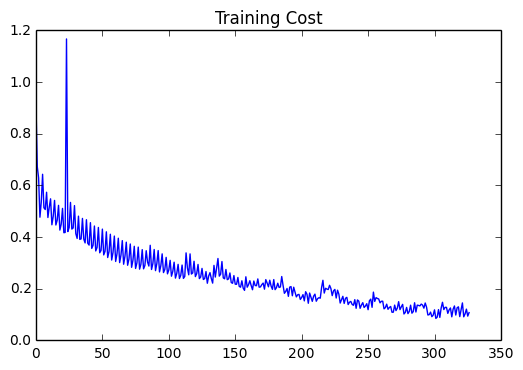

In [186]:
import matplotlib.pyplot as plt
plt.plot(ctraining)
plt.title("Training Cost")
plt.show()

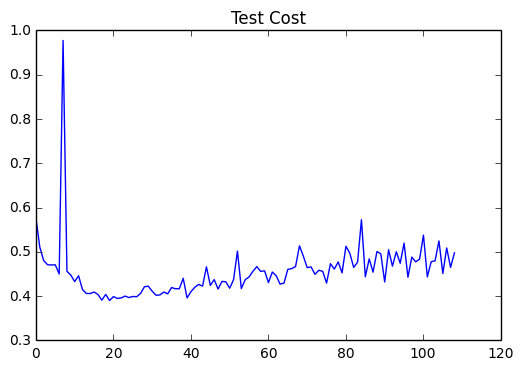

In [187]:
plt.plot(ctest)
plt.title("Test Cost")
plt.show()

In [188]:
np.min(ctraining)

0.085192084

In [1]:
np.min(ctest)

NameError: name 'np' is not defined

## Result

In [ ]:
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    load_path = all_saver.restore(sess, '/Users/lambda/Documents/Code/Lib/Python/TensorFlow/RNN_Prediction_Trained')
    trainingresult=[]
    trainingobserve=[]
    for b in range(ptraining/n_steps):
        epoch_x=x_data[b*n_steps:(b+1)*n_steps,:,:]
        epoch_y=y_data[b*n_steps:(b+1)*n_steps,:]
        trainingresult.append(sess.run(prediction, feed_dict={x: epoch_x}))
        trainingobserve.append(epoch_y)
    testresult=[]
    testobserve=[]
    for b in range(ptest/n_steps):
        epoch_x=x_data[ptraining+b*n_steps:ptraining+(b+1)*n_steps,:,:]
        epoch_y=y_data[ptraining+b*n_steps:ptraining+(b+1)*n_steps,:]
        testresult.append(sess.run(prediction, feed_dict={x: epoch_x}))
        testobserve.append(epoch_y)

In [ ]:
atrainingresult=np.reshape(np.asarray(trainingresult),(ptraining/n_steps*n_steps,1))
atrainingobserve=np.reshape(np.asarray(trainingobserve),(ptraining/n_steps*n_steps,1))
atestresult=np.reshape(np.asarray(testresult),(ptest/n_steps*n_steps,1))
atestobserve=np.reshape(np.asarray(testobserve),(ptest/n_steps*n_steps,1))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(atrainingresult,atrainingobserve,'ro')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(atestresult,atestobserve,'ro')
plt.show()

In [ ]:
map(lambda m:np.corrcoef(map(lambda x:x[0],atrainingresult[m:len(atestresult):12].tolist()),
                         map(lambda x:x[0],atrainingobserve[m:len(atestresult):12].tolist()))[0][1],
    range(12))

In [ ]:
map(lambda m:np.corrcoef(map(lambda x:x[0],atestresult[m:len(atestresult):12].tolist()),
                         map(lambda x:x[0],atestobserve[m:len(atestresult):12].tolist()))[0][1],
    range(12))